# Stellar Classification SDSS-17
## author: Daniel Jarzymowski


# 1 Introduction

## 1.1 Aim of project

The aim of this project is to build a classificator, which would indicate if the measured object is a star, a galaxy or a Quasar. In addition, I intend to show that balancing data and standardization can make a huge difference.

## 1.2 Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Dropout
from keras.callbacks import History
from keras.utils import to_categorical
from collections import Counter
from imblearn.over_sampling import SMOTE
from keras.optimizers import Adam, SGD

## 1.3 About data
The data is taken from kaggle(https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17 ). It consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. alpha = Right Ascension angle (at J2000 epoch)
3. delta = Declination angle (at J2000 epoch)
4. u = Ultraviolet filter in the photometric system
5. g = Green filter in the photometric system
6. r = Red filter in the photometric system
7. i = Near Infrared filter in the photometric system
8. z = Infrared filter in the photometric system
9. run_ID = Run Number used to identify the specific scan
10. rereun_ID = Rerun Number to specify how the image was processed
11. cam_col = Camera column to identify the scanline within the run
12. field_ID = Field number to identify each field
13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. class = object class (galaxy, star or quasar object)
15. redshift = redshift value based on the increase in wavelength
16. plate = plate ID, identifies each plate in SDSS
17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

# 2 First look into data

Importing dataset file 

In [2]:
data = pd.read_csv('star_classification.csv')

In [3]:
data.head(10)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


In [4]:
data.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


It can be seen, that there are values, which doesn't make sense, such as -9999. These are outliers. To get rid of them, I will use LocalOutlierFactor function from sklearn.

# 3 Preprocessing

First I change classes to numbers: "GALAXY" - 0, "Star" - 1, "QSO" - 2

In [5]:
data["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in data["class"]]

In [6]:
clf = LocalOutlierFactor()
clf.fit_predict(data) # fitting outlier detector
x_score = clf.negative_outlier_factor_ # getting score for each record
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score # saving score to dataframe

#filter for dropping                                           
filter2 = outlier_score["score"] < -1.5 #  all records with outlier score less than -1.5 will be dropped
outlier_index = outlier_score[filter2].index.tolist() # creating list of indexes to delete
data.drop(outlier_index, inplace=True)

In [7]:
data.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
count,8.474600e+04,84746.000000,84746.000000,84746.000000,84746.000000,84746.000000,84746.000000,84746.000000,84746.000000,84746.0,84746.000000,84746.000000,8.474600e+04,84746.000000,84746.000000,84746.000000,84746.000000,84746.000000
mean,1.237665e+18,178.101250,24.016513,22.075138,20.624655,19.639618,19.080727,18.765849,4481.310847,301.0,3.539707,185.658485,5.760702e+18,0.592465,0.577127,5116.421011,55574.453001,450.008449
std,8.413370e+12,96.526583,19.611225,2.242892,2.025268,1.847455,1.755296,1.765619,1958.899752,0.0,1.584227,149.047205,3.321597e+18,0.789182,0.728731,2950.155223,1813.290847,270.255489
min,1.237646e+18,0.005528,-17.636198,10.996230,12.679020,11.746640,11.299560,10.897380,109.000000,301.0,1.000000,11.000000,2.995191e+17,0.000000,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,128.136967,4.698132,20.350460,18.959375,18.125643,17.723150,17.445285,3187.000000,301.0,2.000000,82.000000,2.802408e+18,0.000000,0.060012,2489.000000,54212.000000,224.000000
50%,1.237663e+18,181.293281,23.730643,22.165595,21.086370,20.114135,19.397110,18.999470,4188.000000,301.0,4.000000,146.000000,5.604917e+18,0.000000,0.424282,4978.000000,55866.000000,435.000000
75%,1.237668e+18,233.944623,39.807760,23.672718,22.116512,21.029507,20.384258,19.922400,5323.000000,301.0,5.000000,239.000000,8.322690e+18,1.000000,0.704136,7392.000000,56772.000000,643.000000
max,1.237681e+18,359.999810,79.343076,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412685e+19,2.000000,7.011245,12547.000000,58932.000000,1000.000000


Most negatives values, were  dropped. There are only two: in delta and in redshift. However, these seem to be fine, so I decided to keep them in this dataset.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84746 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obj_ID       84746 non-null  float64
 1   alpha        84746 non-null  float64
 2   delta        84746 non-null  float64
 3   u            84746 non-null  float64
 4   g            84746 non-null  float64
 5   r            84746 non-null  float64
 6   i            84746 non-null  float64
 7   z            84746 non-null  float64
 8   run_ID       84746 non-null  int64  
 9   rerun_ID     84746 non-null  int64  
 10  cam_col      84746 non-null  int64  
 11  field_ID     84746 non-null  int64  
 12  spec_obj_ID  84746 non-null  float64
 13  class        84746 non-null  int64  
 14  redshift     84746 non-null  float64
 15  plate        84746 non-null  int64  
 16  MJD          84746 non-null  int64  
 17  fiber_ID     84746 non-null  int64  
dtypes: float64(10), int64(8)
memory usage: 12.3 MB

Our dataset doesn't contain any NaN values. However, there is a different problem with it. The size of each class is not balanced:

In [9]:
data['class'].value_counts()

0    50696
1    17891
2    16159
Name: class, dtype: int64

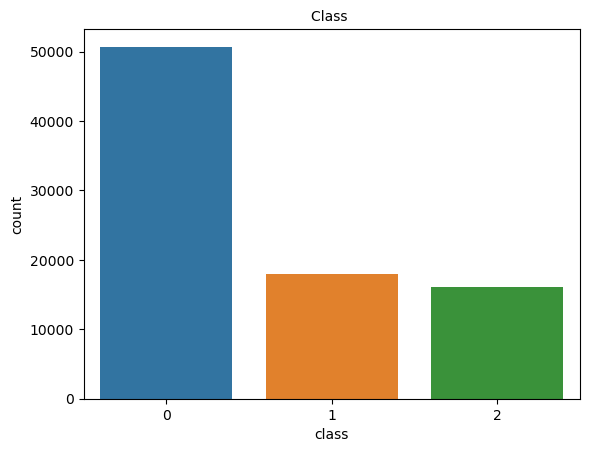

In [10]:
sns.countplot(data, x= 'class')
plt.title("Class ",fontsize=10)
plt.show()

I decided to try two different approaches: first one is to classify with such unbalanced classes and without standardization. In the second approach, I will use oversampling to balance all classes and standardize all data.

# 4 Feature selection

For selecting features, I decided to use anova.

In [11]:
X = data.drop('class', axis = 1)
y = data['class']

In [12]:
best_features = SelectKBest(score_func = f_classif, k = 10)
kbest_anova = best_features.fit(X, y)
anova_feats = [feat for feat in list(kbest_anova.get_support()*X.columns) if feat !=''] 
# get_support gives boolean list , where True  means that feature have impact on target fature
anova_feats

C:\Users\danio\Anaconda3\envs\roj\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\danio\Anaconda3\envs\roj\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


['u',
 'g',
 'r',
 'i',
 'z',
 'spec_obj_ID',
 'redshift',
 'plate',
 'MJD',
 'fiber_ID']

In [13]:
X = X[anova_feats] # taking from dataset only those features, which have impact on target column

# 5 Fitting models - first approach

To build a classificator I need to decide, which model works great for this data. I decided to verify models such as, Decision Tree, Naive Bayes, KNN and some Neural Networks.

Splitting data to train and test sets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 275)

## 5.1 Decision Tree, max_depth 5

First model to check is decision tree, in which I decided to limit its depth

In [15]:
dt_cut = DecisionTreeClassifier(max_depth = 5) # building simple model, which will be used in gridsearch
params = [{
    'criterion' : ['gini','entropy','log_loss'],
    'splitter' : ['best', 'random'],
    'max_features' : ['sqrt', 'log2']
}]
grid = GridSearchCV(dt_cut, param_grid = params, scoring='accuracy', cv = 5)
grid.fit(X_train, y_train)
grid.best_params_
# gridsearch gives me the best set of model's parameters for my dat

{'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}

In [16]:
dt_cut = DecisionTreeClassifier(max_depth = 5,criterion = 'log_loss', max_features= 'sqrt', splitter= 'best' )
dt_cut.fit(X_train, y_train)
print('Score on train set : ' + str(dt_cut.score(X_train, y_train)))
scores_dt_cut = cross_val_score(dt_cut, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_dt_cut.mean(), scores_dt_cut.std()))
# cross val score measures mean score and devation of score for this model
pred_dt_cut = dt_cut.predict(X_test)
print('Score on test set : ' + str(dt_cut.score(X_test, y_test)))

Score on train set : 0.881494217996696
Cross validation score: 0.90 accuracy with a standard deviation of 0.05
Score on test set : 0.8777139710509755


Score of this model is quite high, but cross validation score indicates, that for different divisions of training and test sets this score would be different. Still, results are good, when you consider that I fed the model with unbalanced and not standardized data.

In [17]:
print(classification_report(y_test, pred_dt_cut))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     15212
           1       0.94      0.74      0.83      5310
           2       0.78      0.77      0.78      4902

    accuracy                           0.88     25424
   macro avg       0.87      0.82      0.84     25424
weighted avg       0.88      0.88      0.88     25424



Despite the unbalanced and not standardized data, results of this model are quite good. It only struggles a little with the last class, as it is the  smallest class.

## 5.2 Decision Tree without max depth

Now I will check if decision tree with limited depth will have better results

In [18]:
dt = DecisionTreeClassifier()
params = [{
    'criterion' : ['gini','entropy','log_loss'],
    'splitter' : ['best', 'random'],
    'max_features' : ['sqrt', 'log2']
}]
grid = GridSearchCV(dt, param_grid = params, scoring='accuracy', cv = 5)
grid.fit(X_train, y_train)
grid.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}

In [19]:
dt = DecisionTreeClassifier(criterion = 'log_loss', max_features= 'log2', splitter= 'best' )
dt.fit(X_train, y_train)
print('Score on train set : ' + str(dt.score(X_train, y_train)))
scores_dt = cross_val_score(dt, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_dt.mean(), scores_dt.std()))
pred_dt = dt.predict(X_test)
print('Score on test set : ' + str(dt.score(X_test, y_test)))

Score on train set : 1.0
Cross validation score: 0.96 accuracy with a standard deviation of 0.00
Score on test set : 0.9572844556324732


In [20]:
scores_dt

array([0.95802781, 0.95592078, 0.95625421, 0.95279838, 0.96291301])

In [21]:
scores_dt.std()

0.003323477172414516

Now, cross validation score  is near the results for train and test set, which shows that this model is very stable and well-trained.

In [20]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     15212
           1       0.99      0.99      0.99      5310
           2       0.91      0.91      0.91      4902

    accuracy                           0.96     25424
   macro avg       0.96      0.96      0.96     25424
weighted avg       0.96      0.96      0.96     25424



Without restricting the max_depth parameter, the model worked better with each of the target classes. However, it still struggles with the smallest class a little.

## 5.3 Naive Bayes

The next model is Naive Bayes. Here I don't use grid search, as GaussianNB model doesn't have many parameters, so I decided to use the basic model.

In [21]:
gnb = GaussianNB()

In [22]:
gnb.fit(X_train, y_train)
print('Score on train set : ' + str(gnb.score(X_train, y_train)))
scores_gnb = cross_val_score(gnb, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_gnb.mean(), scores_gnb.std()))
pred_gnb = gnb.predict(X_test)
print('Score on test set : ' + str(gnb.score(X_test, y_test)))

Score on train set : 0.602289201308115
Cross validation score: 0.60 accuracy with a standard deviation of 0.00
Score on test set : 0.6034062303335431


Cross validation score is the same as score for training set, but all the results are really low.

In [23]:
print(classification_report(y_test, pred_gnb, zero_division=1)) 
# I use zero_division parameter to 1 to avoid showing warnig when zero_division happens

              precision    recall  f1-score   support

           0       0.61      0.97      0.75     15212
           1       1.00      0.00      0.00      5310
           2       0.48      0.12      0.19      4902

    accuracy                           0.60     25424
   macro avg       0.70      0.36      0.31     25424
weighted avg       0.67      0.60      0.48     25424



Here it can be easily seen, that Naive Bayes model worked terrible with the smaller classes. Even the results for the biggest classes aren't that good.

## 5.4 K Nearest Neighbours model (KNN)

I decided to check KNN model for 3,5,8 and 12 neighbors. For each of these models, I use grid search to find the best sets of parameters.

### 5.4.1 KNN - 3 neighbors

In [24]:
knn_3 = KNeighborsClassifier(n_neighbors=3)
params = [{
    'weights' : ['uniform','distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p' : [1, 2]
}]
grid = GridSearchCV(knn_3, param_grid = params, scoring='accuracy', cv = 5)
grid.fit(X_train, y_train)
grid.best_params_

{'algorithm': 'brute', 'p': 2, 'weights': 'uniform'}

In [25]:
knn_3 = KNeighborsClassifier(n_neighbors=3, algorithm = 'brute', p = 2 , weights= 'uniform')
knn_3.fit(X_train, y_train)
print('Score on train set : ' + str(knn_3.score(X_train, y_train)))
scores_knn_3 = cross_val_score(knn_3, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_knn_3.mean(), scores_knn_3.std()))
pred_knn_3 = knn_3.predict(X_test)
print('Score on test set : ' + str(knn_3.score(X_test, y_test)))

Score on train set : 0.8064630322645898
Cross validation score: 0.69 accuracy with a standard deviation of 0.00
Score on test set : 0.6920232850849591


In this model, score for train set is quite high, but cross validation score shows, that this is due to specific train and test set division. So for any other division, score would be different.

In [26]:
print(classification_report(y_test, pred_knn_3))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80     15212
           1       0.65      0.48      0.56      5310
           2       0.50      0.37      0.43      4902

    accuracy                           0.69     25424
   macro avg       0.63      0.57      0.59     25424
weighted avg       0.68      0.69      0.68     25424



This summary shows, that model struggles with all classes. Results for the biggest class are a little bit higher, but still they are far from the results of both decision trees.

### 5.4.2 KNN - 5 neighbors

In [27]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
params = [{
    'weights' : ['uniform','distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p' : [1, 2]
}]
grid = GridSearchCV(knn_5, param_grid = params, scoring='accuracy', cv = 5)
grid.fit(X_train, y_train)
grid.best_params_

{'algorithm': 'auto', 'p': 2, 'weights': 'uniform'}

In [28]:
knn_5 = KNeighborsClassifier(n_neighbors=5, algorithm = 'auto', p = 2 , weights= 'uniform')
knn_5.fit(X_train, y_train)
print('Score on train set : ' + str(knn_5.score(X_train, y_train)))
scores_knn_5 = cross_val_score(knn_5, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_knn_5.mean(), scores_knn_5.std()))
pred_knn_5 = knn_5.predict(X_test)
print('Score on test set : ' + str(knn_5.score(X_test, y_test)))

Score on train set : 0.7735915849094771
Cross validation score: 0.70 accuracy with a standard deviation of 0.00
Score on test set : 0.7042164883574575


Here score for training set is a little bit higher, but it is near cross validation score.

In [29]:
print(classification_report(y_test, pred_knn_5))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81     15212
           1       0.66      0.49      0.57      5310
           2       0.53      0.36      0.43      4902

    accuracy                           0.70     25424
   macro avg       0.65      0.58      0.60     25424
weighted avg       0.69      0.70      0.69     25424



Just as for the previous KNN model, this also struggles with unbalanced classes.

### 5.4.3 KNN - 8 neighbors

In [30]:
knn_8 = KNeighborsClassifier(n_neighbors=8)
params = [{
    'weights' : ['uniform','distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p' : [1, 2]
}]
grid = GridSearchCV(knn_8, param_grid = params, scoring='accuracy', cv = 5)
grid.fit(X_train, y_train)
grid.best_params_

{'algorithm': 'brute', 'p': 2, 'weights': 'uniform'}

In [31]:
knn_8 = KNeighborsClassifier(n_neighbors=8, algorithm = 'brute', p = 2 , weights= 'uniform')
knn_8.fit(X_train, y_train)
print('Score on train set : ' + str(knn_8.score(X_train, y_train)))
scores_knn_8 = cross_val_score(knn_8, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_knn_8.mean(), scores_knn_8.std()))
pred_knn_8 = knn_8.predict(X_test)
print('Score on test set : ' + str(knn_8.score(X_test, y_test)))

Score on train set : 0.7563804322173898
Cross validation score: 0.71 accuracy with a standard deviation of 0.00
Score on test set : 0.7091724354940214


Here, the score of cross validation is near the score for training set, which is fine.

In [32]:
print(classification_report(y_test, pred_knn_8))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81     15212
           1       0.71      0.47      0.57      5310
           2       0.54      0.38      0.45      4902

    accuracy                           0.71     25424
   macro avg       0.66      0.58      0.61     25424
weighted avg       0.70      0.71      0.69     25424



This model also struggles with unbalanced data.

### 5.4.4 KNN - 12 neighbors

In [33]:
knn_12 = KNeighborsClassifier(n_neighbors=12)
params = [{
    'weights' : ['uniform','distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p' : [1, 2]
}]
grid = GridSearchCV(knn_12, param_grid = params, scoring='accuracy', cv = 5)
grid.fit(X_train, y_train)
grid.best_params_

{'algorithm': 'brute', 'p': 2, 'weights': 'uniform'}

In [34]:
knn_12 = KNeighborsClassifier(n_neighbors=12, algorithm = 'brute', p = 2 , weights= 'uniform')
knn_12.fit(X_train, y_train)
print('Score on train set : ' + str(knn_12.score(X_train, y_train)))
scores_knn_12 = cross_val_score(knn_12, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_knn_12.mean(), scores_knn_12.std()))
pred_knn_12 = knn_12.predict(X_test)
print('Score on test set : ' + str(knn_12.score(X_test, y_test)))

Score on train set : 0.7441589966622838
Cross validation score: 0.71 accuracy with a standard deviation of 0.00
Score on test set : 0.7145610446821901


In this case, the score of cross validation is also near the score for training set.

In [35]:
print(classification_report(y_test, pred_knn_12))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81     15212
           1       0.77      0.46      0.57      5310
           2       0.54      0.41      0.46      4902

    accuracy                           0.71     25424
   macro avg       0.68      0.59      0.62     25424
weighted avg       0.71      0.71      0.70     25424



Even the KNN model with the biggest number of neighbors struggles with unbalanced data.

### 5.4.5 Summary of KNN models

Results of all KNN models shows that increasing the numbers of neighbors increase the result a little bit, but the model still struggles with unbalanced data.

## 5.5 Neural Networks

To use neural network I coded target classe as arrays in which one stand on the place indictaing number in target class. So if 1 stand at first place it is a galaxy, when in second place in is a star and whne i third place it is a quasar.

In [36]:
y_cat = to_categorical(y)
print(y_cat) # showing how encoded classes look like
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.3, random_state = 275)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


### 5.5.1 Keras NN1

In the first neural network I have hidden layer with 15 neurons and relu* activation. Then I use dropout technique. Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass.  My output layer has 3 neurons and softmax activation. I use softmax to get probability of each class as an output. For compilation, I use SGD optimizer with learnig rate set to 0.01, for loss categorical cross entropy and accuracy for metrics.

*The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

In [37]:
# define the model
model1 = Sequential()
model1.add(Dense(15, input_shape=(10,), activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(3, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate = 0.01), metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                165       
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 48        
                                                                 
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________


In [38]:
# fit model
history1 = History() # will be used for getting loss
model1.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50,
          batch_size=20,verbose=1, callbacks=[history1])

Epoch 1/50
2967/2967 [==============================] - 10s 3ms/step - loss: nan - accuracy: 0.5980 - val_loss: nan - val_accuracy: 0.5983
Epoch 2/50
2967/2967 [==============================] - 9s 3ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 3/50
2967/2967 [==============================] - 9s 3ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 4/50
2967/2967 [==============================] - 8s 3ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 5/50
2967/2967 [==============================] - 10s 4ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 6/50
2967/2967 [==============================] - 8s 3ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 7/50
2967/2967 [==============================] - 9s 3ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 8/50
2967/2967 [==========

Loss was so big, that Nan value was shown

In [39]:
y_test_class = np.argmax(y_test, axis=1)
# argmax get index of the max value in array. This allows me to get back numbers from my encoded target column
pred_nn1 = model1.predict(X_test)# predictions of the model
pred_nn1_classes = np.argmax(pred_nn1, axis=1) 
# getting index of the highet propability in the array to get class predicted by the model

795/795 [==============================] - 2s 1ms/step


In [40]:
print(classification_report(y_test_class, pred_nn1_classes, zero_division = 1))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75     15212
           1       1.00      0.00      0.00      5310
           2       1.00      0.00      0.00      4902

    accuracy                           0.60     25424
   macro avg       0.87      0.33      0.25     25424
weighted avg       0.76      0.60      0.45     25424



In [41]:
np.array(np.unique(pred_nn1_classes, return_counts=True)).T

array([[    0, 25424]], dtype=int64)

As we can see, neural network classified all samples to the largest group. This problem could be cause either  by dying relu or by the fact that the data is unbalanced and unstandardized. I will verify this in the second approach.

Because loss has only NaN values there is no point in drawing loss curve.

### 5.5.2 Keras NN2

This neural network contains tow hidden layers. First one contains 15 neurons and leakyrelu* activation with alpha equal -0.01. Such alpha will make all negative values  positive values. Second layer has 7 neurons and relu activation. Output layer is the same as in the first neural network. For compilation, I use SGD optimizer, for loss categorical cross entropy and accuracy for metrics.

*Leaky Rectified Linear Unit, or Leaky ReLU, is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. The slope coefficient is determined before training, i.e. it is not learnt during training. This type of activation function is popular in tasks where we may suffer from sparse gradients, for example training generative adversarial networks.

In [43]:
# define the model
model2 = Sequential()
model2.add(Dense(15, input_shape=(10,), activation=LeakyReLU(alpha=-0.01)))
model2.add(Dense(7, activation = 'relu'))
model2.add(Dense(3, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                165       
                                                                 
 dense_3 (Dense)             (None, 7)                 112       
                                                                 
 dense_4 (Dense)             (None, 3)                 24        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [44]:
# fit model
history2 = History() # will be used for getting loss
model2.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50,
          batch_size=20,verbose=1, callbacks=[history2])

Epoch 1/50
2967/2967 [==============================] - 9s 3ms/step - loss: nan - accuracy: 0.5980 - val_loss: nan - val_accuracy: 0.5983
Epoch 2/50
2967/2967 [==============================] - 8s 3ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 3/50
2967/2967 [==============================] - 8s 3ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 4/50
2967/2967 [==============================] - 8s 3ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 5/50
2967/2967 [==============================] - 8s 3ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 6/50
2967/2967 [==============================] - 7s 2ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 7/50
2967/2967 [==============================] - 7s 2ms/step - loss: nan - accuracy: 0.5982 - val_loss: nan - val_accuracy: 0.5983
Epoch 8/50
2967/2967 [============

In [45]:
y_test_class = np.argmax(y_test, axis=1)
pred_nn2 = model2.predict(X_test)
pred_nn2_classes = np.argmax(pred_nn2, axis=1)

795/795 [==============================] - 2s 2ms/step


In [46]:
print(classification_report(y_test_class, pred_nn2_classes, zero_division=1))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75     15212
           1       1.00      0.00      0.00      5310
           2       1.00      0.00      0.00      4902

    accuracy                           0.60     25424
   macro avg       0.87      0.33      0.25     25424
weighted avg       0.76      0.60      0.45     25424



In [47]:
np.array(np.unique(pred_nn2_classes, return_counts=True)).T

array([[    0, 25424]], dtype=int64)

Here is the same problem as in the previous neural network.

Because here loss has also only NaN values, I won't draw the loss curve.

### 5.5.3 Keras NN3

Thid neural network has the same structure as the first neural network, but here I decided to use Adam as optimizer.

In [49]:
# define the model
model3= Sequential()
model3.add(Dense(15, input_shape=(10,), activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(3, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01),metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 15)                165       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 48        
                                                                 
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________


In [50]:
# fit model
history3 = History() # will be used for getting loss
model3.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50,
          batch_size=20,verbose=1, callbacks=[history3])

Epoch 1/50
2967/2967 [==============================] - 9s 3ms/step - loss: 6404501149843456.0000 - accuracy: 0.5244 - val_loss: 0.9526 - val_accuracy: 0.5983
Epoch 2/50
2967/2967 [==============================] - 9s 3ms/step - loss: 0.9522 - accuracy: 0.5982 - val_loss: 0.9522 - val_accuracy: 0.5983
Epoch 3/50
2967/2967 [==============================] - 10s 3ms/step - loss: 0.9523 - accuracy: 0.5982 - val_loss: 0.9523 - val_accuracy: 0.5983
Epoch 4/50
2967/2967 [==============================] - 8s 3ms/step - loss: 0.9524 - accuracy: 0.5982 - val_loss: 0.9534 - val_accuracy: 0.5983
Epoch 5/50
2967/2967 [==============================] - 8s 3ms/step - loss: 0.9523 - accuracy: 0.5982 - val_loss: 0.9521 - val_accuracy: 0.5983
Epoch 6/50
2967/2967 [==============================] - 8s 3ms/step - loss: 0.9524 - accuracy: 0.5982 - val_loss: 0.9531 - val_accuracy: 0.5983
Epoch 7/50
2967/2967 [==============================] - 8s 3ms/step - loss: 0.9525 - accuracy: 0.5982 - val_loss: 0.9519

In [51]:
y_test_class = np.argmax(y_test, axis=1)
pred_nn3 = model3.predict(X_test)
pred_nn3_classes = np.argmax(pred_nn3, axis=1)

795/795 [==============================] - 1s 2ms/step


In [52]:
print(classification_report(y_test_class, pred_nn3_classes, zero_division=1))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75     15212
           1       1.00      0.00      0.00      5310
           2       1.00      0.00      0.00      4902

    accuracy                           0.60     25424
   macro avg       0.87      0.33      0.25     25424
weighted avg       0.76      0.60      0.45     25424



In [53]:
np.array(np.unique(pred_nn3_classes, return_counts=True)).T

array([[    0, 25424]], dtype=int64)

Here there is the same problem as in the previous neural networks.

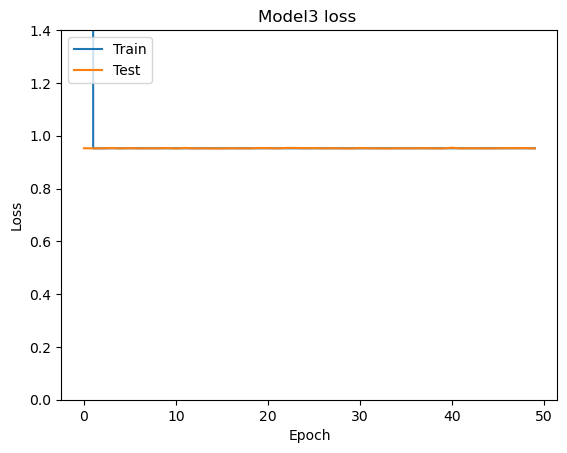

In [54]:
fig,ax = plt.subplots()
ax.plot(history3.history['loss'])
ax.plot(history3.history['val_loss'])
ax.set_ylim(0, 1.4)
ax.set_title('Model3 loss ')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

The loss curve shows that the model couldn't learn anything better, which shows that unbalanced and not standardized data is problematic for neural network.

# 6  Summary

Only decisions tree worked fine for unstandardized and unbalanced data.Now I will check the same models, but first I will use SMOTE function for oversampling unbalanced data and then standardize data.

# 7 Second approach preprocessing

## 7.1 Balancing data

In [55]:
print('Original dataset shape %s' % Counter(data['class']))
sm = SMOTE(random_state = 275)
X, y = sm.fit_resample(X, data['class'])
print('Resampled dataset shape %s' % Counter(y))
# Smote upsamples data for smaller calsses up to the count of the bigget class

Original dataset shape Counter({0: 50696, 1: 17891, 2: 16159})
Resampled dataset shape Counter({0: 50696, 2: 50696, 1: 50696})


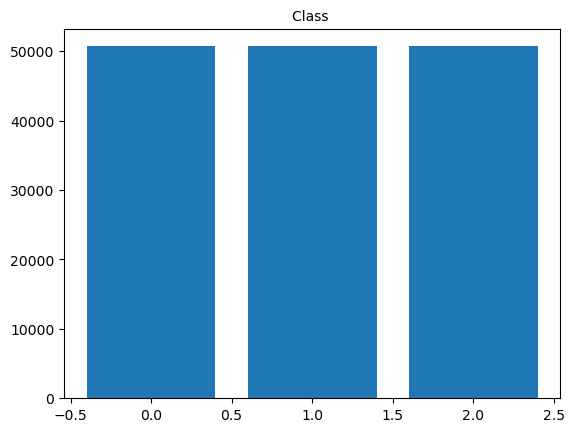

In [56]:
labels = Counter(y).keys()
values = Counter(y).values()
plt.bar(labels, values)
plt.title("Class ",fontsize=10)
plt.show()

All classes are balanced. This should make models more accurate.

## 7.2 Standarization

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 275)

# 8 fitting models - second approach

## 8.1 Decision Tree, max_depth 5

In [59]:
dt_cut_balanced = DecisionTreeClassifier(max_depth = 5)
params = [{
    'criterion' : ['gini','entropy','log_loss'],
    'splitter' : ['best', 'random'],
    'max_features' : ['sqrt', 'log2']
}]
grid = GridSearchCV(dt_cut_balanced, param_grid = params, scoring='accuracy', cv = 5)
grid.fit(X_train, y_train)
grid.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'splitter': 'best'}

In [60]:
dt_cut_balanced = DecisionTreeClassifier(max_depth = 5,criterion = 'gini', max_features= 'log2', splitter= 'best' )
dt_cut_balanced.fit(X_train, y_train)
print('Score on train set : ' + str(dt_cut_balanced.score(X_train, y_train)))
scores_dt_cut_balanced = cross_val_score(dt_cut_balanced, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_dt_cut_balanced.mean(), scores_dt_cut_balanced.std()))
pred_dt_cut_balanced = dt_cut_balanced.predict(X_test)
print('Score on test set : ' + str(dt_cut_balanced.score(X_test, y_test)))

Score on train set : 0.9578437174176458
Cross validation score: 0.90 accuracy with a standard deviation of 0.07
Score on test set : 0.956758059920661


Cross validation score shows that this division of training and test set has a little bit higher result than average score for training and test sets divisions.

In [61]:
print(classification_report(y_test, pred_dt_cut_balanced))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     15194
           1       0.97      1.00      0.98     15273
           2       0.98      0.93      0.95     15160

    accuracy                           0.96     45627
   macro avg       0.96      0.96      0.96     45627
weighted avg       0.96      0.96      0.96     45627



Now model works quite similar for all classes, which result in higher accuracy.

## 8.2 Decision Tree without max depth

In [62]:
dt_balanced = DecisionTreeClassifier()
params = [{
    'criterion' : ['gini','entropy','log_loss'],
    'splitter' : ['best', 'random'],
    'max_features' : ['sqrt', 'log2']
}]
grid = GridSearchCV(dt_balanced, param_grid = params, scoring='accuracy', cv = 5)
grid.fit(X_train, y_train)
grid.best_params_

{'criterion': 'log_loss', 'max_features': 'sqrt', 'splitter': 'best'}

In [63]:
dt_balanced = DecisionTreeClassifier(criterion = 'gini', max_features= 'log2', splitter= 'best' )
dt_balanced.fit(X_train, y_train)
print('Score on train set : ' + str(dt_balanced.score(X_train, y_train)))
scores_dt_balanced = cross_val_score(dt_balanced, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_dt_balanced.mean(), scores_dt_balanced.std()))
pred_dt_balanced = dt_balanced.predict(X_test)
print('Score on test set : ' + str(dt_balanced.score(X_test, y_test)))

Score on train set : 1.0
Cross validation score: 0.97 accuracy with a standard deviation of 0.00
Score on test set : 0.9713985140377408


Here, cross validation results show that this model for balanced and standardized data  is very stable and accurate.

In [64]:
print(classification_report(y_test, pred_dt_balanced))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     15194
           1       1.00      1.00      1.00     15273
           2       0.96      0.96      0.96     15160

    accuracy                           0.97     45627
   macro avg       0.97      0.97      0.97     45627
weighted avg       0.97      0.97      0.97     45627



Decision tree without max_depth worked great also for unbalanced data, so here only tiny differences could appear, if any.

## 8.3 Naive Bayes

In [65]:
gnb_balanced = GaussianNB()

In [66]:
gnb_balanced.fit(X_train, y_train)
print('Score on train set : ' + str(gnb_balanced.score(X_train, y_train)))
scores_gnb_balanced = cross_val_score(gnb_balanced, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_gnb_balanced.mean(), scores_gnb_balanced.std()))
pred_gnb_balanced = gnb_balanced.predict(X_test)
print('Score on test set : ' + str(gnb_balanced.score(X_test, y_test)))

Score on train set : 0.9042278393026554
Cross validation score: 0.90 accuracy with a standard deviation of 0.00
Score on test set : 0.9051438841037105


Cross validation score is the same as scores of training and test sets, which indicates that the model is very stable and well fitted.

In [67]:
print(classification_report(y_test, pred_gnb_balanced))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86     15194
           1       0.99      0.98      0.99     15273
           2       0.83      0.91      0.87     15160

    accuracy                           0.91     45627
   macro avg       0.91      0.91      0.91     45627
weighted avg       0.91      0.91      0.91     45627



Here huge difference can be seen. For unbalanced and not standarized data naive bayes had only 60% accuracy. Now it is up to 90%. This shows how much difference preprocessing could make.

## 8.4 K Nearest Neighbors

#### In KNN models gridsearch would take so much time for upsampled data, that I decided to use same parameters as in first approach

### 8.4.1 KNN - 3 neighbors

In [68]:
knn_3_balanced = KNeighborsClassifier(n_neighbors=3, algorithm = 'brute', p = 2 , weights= 'uniform')
knn_3_balanced.fit(X_train, y_train)
print('Score on train set : ' + str(knn_3_balanced.score(X_train, y_train)))
scores_knn_3_balanced = cross_val_score(knn_3_balanced, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_knn_3_balanced.mean(), scores_knn_3_balanced.std()))
pred_knn_3_balanced = knn_3_balanced.predict(X_test)
print('Score on test set : ' + str(knn_3_balanced.score(X_test, y_test)))

Score on train set : 0.9717267356121021
Cross validation score: 0.95 accuracy with a standard deviation of 0.00
Score on test set : 0.9484296578780108


In this model cross validation score is closer to score of training set, than in this model in fisrt approach.

In [69]:
print(classification_report(y_test, pred_knn_3_balanced))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     15194
           1       0.94      0.96      0.95     15273
           2       0.97      0.96      0.97     15160

    accuracy                           0.95     45627
   macro avg       0.95      0.95      0.95     45627
weighted avg       0.95      0.95      0.95     45627



Now that classes are balanced, this model works much better than before.

### 8.4.2 KNN - 5 neighbors

In [70]:
knn_5_balanced = KNeighborsClassifier(n_neighbors=5, algorithm = 'auto', p = 2 , weights= 'uniform')
knn_5_balanced.fit(X_train, y_train)
print('Score on train set : ' + str(knn_5_balanced.score(X_train, y_train)))
scores_knn_5_balanced = cross_val_score(knn_5_balanced, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_knn_5_balanced.mean(), scores_knn_5_balanced.std()))
pred_knn_5_balanced = knn_5_balanced.predict(X_test)
print('Score on test set : ' + str(knn_5_balanced.score(X_test, y_test)))

Score on train set : 0.9625027005194391
Cross validation score: 0.95 accuracy with a standard deviation of 0.00
Score on test set : 0.9464790584522322


Here there is the same behavior in the cross validation score as in the previous model.

In [71]:
print(classification_report(y_test, pred_knn_5_balanced))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     15194
           1       0.94      0.96      0.95     15273
           2       0.98      0.96      0.97     15160

    accuracy                           0.95     45627
   macro avg       0.95      0.95      0.95     45627
weighted avg       0.95      0.95      0.95     45627



For this models results are also significantly higher

### 8.4.3 KNN - 8 neighbors

In [72]:
knn_8_balanced = KNeighborsClassifier(n_neighbors=8, algorithm = 'brute', p = 2 , weights= 'uniform')
knn_8_balanced.fit(X_train, y_train)
print('Score on train set : ' + str(knn_8_balanced.score(X_train, y_train)))
scores_knn_8_balanced = cross_val_score(knn_8_balanced, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_knn_8_balanced.mean(), scores_knn_8_balanced.std()))
pred_knn_8_balanced = knn_8_balanced.predict(X_test)
print('Score on test set : ' + str(knn_8_balanced.score(X_test, y_test)))

Score on train set : 0.9535041000929918
Cross validation score: 0.94 accuracy with a standard deviation of 0.00
Score on test set : 0.9411970982093936


Here there is the same behavior in the cross validation score as in the two previous models.

In [73]:
print(classification_report(y_test, pred_knn_8_balanced))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     15194
           1       0.94      0.95      0.94     15273
           2       0.98      0.95      0.97     15160

    accuracy                           0.94     45627
   macro avg       0.94      0.94      0.94     45627
weighted avg       0.94      0.94      0.94     45627



In this model, accuracy is also much higher than in the model with unbalanced and unstandardized  data.

### 8.4.4 KNN - 12 neighbors

In [74]:
knn_12_balanced = KNeighborsClassifier(n_neighbors=12, algorithm = 'brute', p = 2 , weights= 'uniform')
knn_12_balanced.fit(X_train, y_train)
print('Score on train set : ' + str(knn_12_balanced.score(X_train, y_train)))
scores_knn_12_balanced = cross_val_score(knn_12_balanced, X_train, y_train, cv=5)
print('Cross validation score: %0.2f accuracy with a standard deviation of %0.2f' % (scores_knn_12_balanced.mean(), scores_knn_12_balanced.std()))
pred_knn_12_balanced = knn_12_balanced.predict(X_test)
print('Score on test set : ' + str(knn_12_balanced.score(X_test, y_test)))

Score on train set : 0.9481875992147359
Cross validation score: 0.94 accuracy with a standard deviation of 0.00
Score on test set : 0.9384574922743113


Cross validation score is the same as scores for training set, which shows that this modle is stable.

In [75]:
print(classification_report(y_test, pred_knn_12_balanced))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     15194
           1       0.93      0.95      0.94     15273
           2       0.98      0.95      0.96     15160

    accuracy                           0.94     45627
   macro avg       0.94      0.94      0.94     45627
weighted avg       0.94      0.94      0.94     45627



And in the last KNN model result are also much better.

### 8.4.5 Summary of KNN

All of KNN models work better after balancing and standardizing data. What can be seen is the fact, that models with fewer neighbors work a little bit better, but I personally believe that this is not a significant difference.

## 8.5  Neural Networks

All methods and hyperparameters I described in the neural network in first approach, so I will only comment results here.

In [76]:
y_cat = to_categorical(y)
print(y_cat)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.3, random_state = 275)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


### 8.5.1 Keras NN1

In [77]:
# define the model
model1_balanced = Sequential()
model1_balanced.add(Dense(15, input_shape=(10,), activation='relu'))
model1_balanced.add(Dropout(0.2))
model1_balanced.add(Dense(3, activation='softmax'))
model1_balanced.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate = 0.01), metrics=['accuracy'])
model1_balanced.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 15)                165       
                                                                 
 dropout_2 (Dropout)         (None, 15)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 48        
                                                                 
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________


In [78]:
# fit model
history1_balanced = History() # will be used for getting loss
model1_balanced.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50,
          batch_size=20,verbose=1, callbacks=[history1_balanced])

Epoch 1/50
5324/5324 [==============================] - 15s 3ms/step - loss: 0.4627 - accuracy: 0.8115 - val_loss: 0.2513 - val_accuracy: 0.9262
Epoch 2/50
5324/5324 [==============================] - 14s 3ms/step - loss: 0.2469 - accuracy: 0.9200 - val_loss: 0.1832 - val_accuracy: 0.9463
Epoch 3/50
5324/5324 [==============================] - 14s 3ms/step - loss: 0.2027 - accuracy: 0.9384 - val_loss: 0.2241 - val_accuracy: 0.9077
Epoch 4/50
5324/5324 [==============================] - 14s 3ms/step - loss: 0.1841 - accuracy: 0.9440 - val_loss: 0.1547 - val_accuracy: 0.9483
Epoch 5/50
5324/5324 [==============================] - 15s 3ms/step - loss: 0.1726 - accuracy: 0.9481 - val_loss: 0.1398 - val_accuracy: 0.9576
Epoch 6/50
5324/5324 [==============================] - 14s 3ms/step - loss: 0.1638 - accuracy: 0.9499 - val_loss: 0.1319 - val_accuracy: 0.9617
Epoch 7/50
5324/5324 [==============================] - 13s 3ms/step - loss: 0.1567 - accuracy: 0.9524 - val_loss: 0.1293 - val_ac

In [79]:
y_test_class = np.argmax(y_test, axis=1)
pred_nn1_balanced = model1_balanced.predict(X_test)
pred_nn1_classes_balanced = np.argmax(pred_nn1_balanced, axis=1)

1426/1426 [==============================] - 2s 1ms/step


In [80]:
print(classification_report(y_test_class, pred_nn1_classes_balanced))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     15194
           1       0.98      1.00      0.99     15273
           2       0.97      0.96      0.96     15160

    accuracy                           0.97     45627
   macro avg       0.97      0.97      0.97     45627
weighted avg       0.97      0.97      0.97     45627



In this case, the neural network worked brilliant for all classes. The impact of balancing and standardization can be easily seen here.

In [95]:
np.array(np.unique(pred_nn1_classes_balanced, return_counts=True)).T # numbers of predictions of each class

array([[    0, 15071],
       [    1, 15530],
       [    2, 15026]], dtype=int64)

Loss curve

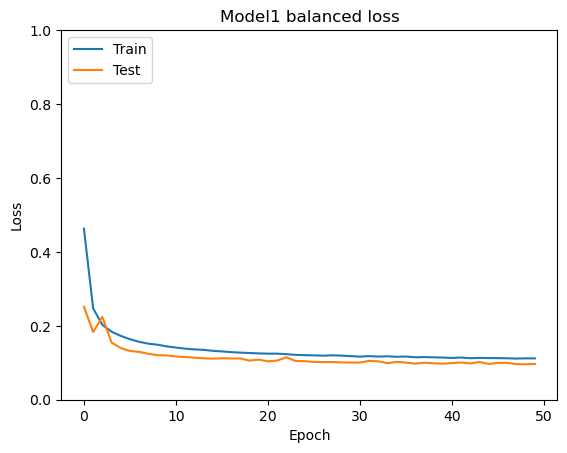

In [101]:
fig,ax = plt.subplots()
ax.plot(history1_balanced.history['loss'])
ax.plot(history1_balanced.history['val_loss'])
ax.set_title('Model1 balanced loss')
ax.set_ylim(0, 1)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

Loss of the test set is lower than los of the training set. This shows, that neural network should be learned more. This could be cause by the droput, as dropout should be used in the neural networks with a big structure.

## 8.5.2 Keras NN2

In [83]:
# define the model
model2_balanced = Sequential()
model2_balanced.add(Dense(15, input_shape=(10,), activation=LeakyReLU(alpha=-0.01)))
model2_balanced.add(Dense(7, activation = 'relu'))
model2_balanced.add(Dense(3, activation='softmax'))
model2_balanced.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
model2_balanced.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 15)                165       
                                                                 
 dense_10 (Dense)            (None, 7)                 112       
                                                                 
 dense_11 (Dense)            (None, 3)                 24        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [84]:
# fit model
history2_balanced = History() # will be used for getting loss
model2_balanced.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50,
          batch_size=20,verbose=1, callbacks=[history2_balanced])

Epoch 1/50
5324/5324 [==============================] - 15s 3ms/step - loss: 0.3047 - accuracy: 0.8864 - val_loss: 0.1645 - val_accuracy: 0.9434
Epoch 2/50
5324/5324 [==============================] - 15s 3ms/step - loss: 0.1459 - accuracy: 0.9517 - val_loss: 0.1309 - val_accuracy: 0.9585
Epoch 3/50
5324/5324 [==============================] - 17s 3ms/step - loss: 0.1260 - accuracy: 0.9591 - val_loss: 0.1241 - val_accuracy: 0.9599
Epoch 4/50
5324/5324 [==============================] - 14s 3ms/step - loss: 0.1172 - accuracy: 0.9625 - val_loss: 0.1121 - val_accuracy: 0.9640
Epoch 5/50
5324/5324 [==============================] - 14s 3ms/step - loss: 0.1120 - accuracy: 0.9643 - val_loss: 0.1052 - val_accuracy: 0.9668
Epoch 6/50
5324/5324 [==============================] - 13s 3ms/step - loss: 0.1087 - accuracy: 0.9650 - val_loss: 0.1042 - val_accuracy: 0.9662
Epoch 7/50
5324/5324 [==============================] - 14s 3ms/step - loss: 0.1066 - accuracy: 0.9654 - val_loss: 0.1404 - val_ac

In [85]:
y_test_class = np.argmax(y_test, axis=1)
pred_nn2_balanced = model2_balanced.predict(X_test)
pred_nn2_classes_balanced = np.argmax(pred_nn2_balanced, axis=1)

1426/1426 [==============================] - 3s 2ms/step


In [86]:
print(classification_report(y_test_class, pred_nn2_classes_balanced))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     15194
           1       0.99      1.00      0.99     15273
           2       0.97      0.96      0.97     15160

    accuracy                           0.97     45627
   macro avg       0.97      0.97      0.97     45627
weighted avg       0.97      0.97      0.97     45627



This neural network also wokrs great for all classes.

In [87]:
np.array(np.unique(pred_nn2_classes_balanced, return_counts=True)).T

array([[    0, 15120],
       [    1, 15477],
       [    2, 15030]], dtype=int64)

Loss curve

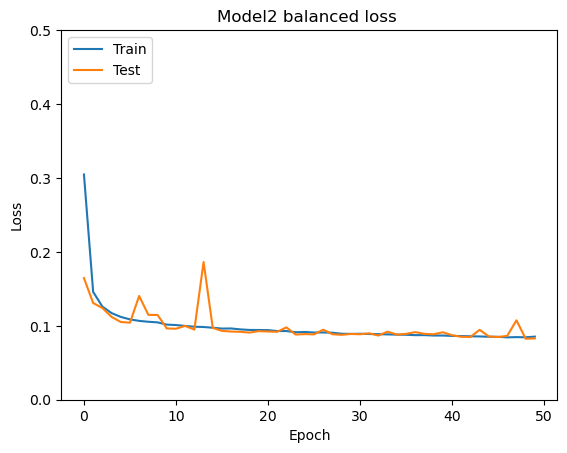

In [97]:
fig,ax = plt.subplots()
ax.plot(history2_balanced.history['loss'])
ax.plot(history2_balanced.history['val_loss'])
ax.set_title('Model2 balanced loss ')
ax.set_ylim(0,0.5)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

Here, the behavior of loss function for the test set is not stable at the beginning. But it can be seen, that fitting this model could be ended a little bit earlier, as  both loss functions has decreased to the point of stability. Continued training of this fit could likely lead to an overfit.

### 8.5.3 Keras NN3

In [89]:
# define the model
model3_balanced = Sequential()
model3_balanced.add(Dense(15, input_shape=(10,), activation='relu'))
model3_balanced.add(Dropout(0.2))
model3_balanced.add(Dense(3, activation='softmax'))
model3_balanced.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
model3_balanced.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 15)                165       
                                                                 
 dropout_3 (Dropout)         (None, 15)                0         
                                                                 
 dense_13 (Dense)            (None, 3)                 48        
                                                                 
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________


In [90]:
# fit model
history3_balanced = History() # will be used for getting loss
model3_balanced.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50,
          batch_size=20,verbose=1, callbacks=[history3_balanced])

Epoch 1/50
5324/5324 [==============================] - 17s 3ms/step - loss: 0.2072 - accuracy: 0.9288 - val_loss: 0.1638 - val_accuracy: 0.9412
Epoch 2/50
5324/5324 [==============================] - 21s 4ms/step - loss: 0.1615 - accuracy: 0.9478 - val_loss: 0.1245 - val_accuracy: 0.9623
Epoch 3/50
5324/5324 [==============================] - 17s 3ms/step - loss: 0.1515 - accuracy: 0.9511 - val_loss: 0.1411 - val_accuracy: 0.9565
Epoch 4/50
5324/5324 [==============================] - 15s 3ms/step - loss: 0.1483 - accuracy: 0.9524 - val_loss: 0.1304 - val_accuracy: 0.9608
Epoch 5/50
5324/5324 [==============================] - 22s 4ms/step - loss: 0.1479 - accuracy: 0.9527 - val_loss: 0.1856 - val_accuracy: 0.9408
Epoch 6/50
5324/5324 [==============================] - 15s 3ms/step - loss: 0.1431 - accuracy: 0.9546 - val_loss: 0.1210 - val_accuracy: 0.9604
Epoch 7/50
5324/5324 [==============================] - 15s 3ms/step - loss: 0.1432 - accuracy: 0.9551 - val_loss: 0.1099 - val_ac

In [91]:
y_test_class = np.argmax(y_test, axis=1)
pred_nn3_balanced = model3_balanced.predict(X_test)
pred_nn3_classes_balanced = np.argmax(pred_nn3_balanced, axis=1)

1426/1426 [==============================] - 3s 2ms/step


In [92]:
print(classification_report(y_test_class, pred_nn3_classes_balanced))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     15194
           1       0.99      1.00      0.99     15273
           2       0.97      0.96      0.97     15160

    accuracy                           0.97     45627
   macro avg       0.97      0.97      0.97     45627
weighted avg       0.97      0.97      0.97     45627



This neural network woks as good as the previous one for all classes.

In [93]:
np.array(np.unique(pred_nn3_classes_balanced, return_counts=True)).T

array([[    0, 15152],
       [    1, 15441],
       [    2, 15034]], dtype=int64)

Loss curve

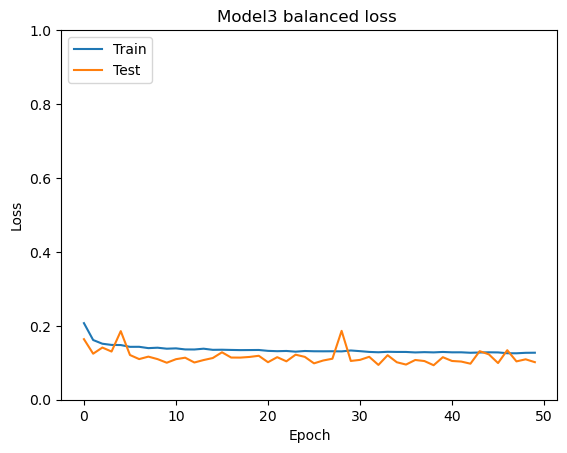

In [100]:
fig,ax = plt.subplots()
ax.plot(history3_balanced.history['loss'])
ax.plot(history3_balanced.history['val_loss'])
ax.set_ylim(0, 1)
ax.set_title('Model3 balanced loss ')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

Here, the same problem as in the first neural network can be seen. Loss of the test set i lower than loss of the trainig set, so network should be learned more. Here, I also used the dropout technnique, so it migth be a good idea to get rid of it.

# 9 Summary

The first conclusion, which can be drawn from this project, is the importance of adequate preprocessing. Results for almost every model were significantly higher in the second approach, in which balanced and standardized data was used. 

A second conclusion is which model to choose. I would say that the safest choice is decision tree without limiting max depth. Why? Because it is the only model, which has the same results in both approaches, which means this mode is more versatile. Of course in the second approach neural networks had the same result as the second decision tree, but in the first approach the differences were huge. Another reason for choosing decision tree as the best model is the amount of time it takes to build model. After upsampling gridsearch for knn was to long, to consider such model. When it comes to neural networks, they took a little bit time to build. In my opinion, neural networks would be better for more complicated classifications, for classifications like in this project decision tree model seems to be enough.